<a href="https://colab.research.google.com/github/robinvvinod/spaceapps/blob/master/CSSE_timeseries_agglomerative_clustering_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import OrderedDict, defaultdict
import seaborn as sns
import numpy as np
from numpy import linalg as LA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs, load_iris

In [198]:

def read_CSSE_data(path):
  df = pd.read_csv(path, index_col=False).drop(columns=["Population"], errors='ignore')
  df["FIPS"] = pd.to_numeric(df["FIPS"], errors='coerce')
  df = df.fillna(0)
  df = df.astype({"FIPS":'int'})
  return df

confirmed = read_CSSE_data("/content/time_series_covid19_confirmed_US_CSSE_clean.csv")
deaths = read_CSSE_data("/content/time_series_covid19_deaths_US_CSSE_clean.csv")

print(confirmed.columns)

demogs = pd.read_csv("/content/county_demographics.csv")

def match_popn(demographics_df, cases_df):
  cases_df_adj = cases_df.merge(demographics_df, how="inner", left_on="fips", right_on="FIPS")
  return cases_df_adj

def create_FIPS_lookup(df):
  lookup = df[["FIPS", "Combined_Key"]]
  return lookup.set_index("FIPS").T.to_dict()

def translate_FIPS(FIPS, lookup):
  try:
    return LU[FIPS]["Combined_Key"]
  except:
    return "FIPS {} not found in lookup".format(FIPS)

LU = create_FIPS_lookup(confirmed)

deaths.head()

# confirmed = match_popn(confirmed, demogs)
# confirmed = confirmed.drop(columns=['Unnamed: 0', 'UID', 'iso2', 'iso3', 'code3', 'Admin2', 'Combined_Key', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'county', 'male', 'female', 'median_age', 'female_percentage','Density per square mile of land area','fips'])
# confirmed.iloc[0:, 2:]  = confirmed.iloc[0:, 2:].div(confirmed.population, axis=0) * 100

# deaths = match_popn(deaths, demogs)
# deaths = deaths.drop(columns=['Unnamed: 0', 'UID', 'iso2', 'iso3', 'code3', 'Admin2', 'Combined_Key', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'county', 'male', 'female', 'median_age', 'female_percentage','Density per square mile of land area','fips'])
# deaths.iloc[0:, 2:]  = deaths.iloc[0:, 2:].div(deaths.population, axis=0) * 100

def preprocess_df(df, demographics_df):
  df = match_popn(df, demographics_df)
  print(df.columns.to_list())
  df = df.drop(columns=['Unnamed: 0', 'UID', 'iso2', 'iso3', 'code3', 'Admin2', 'Combined_Key', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'county', 'male', 'female', 'median_age', 'female_percentage','Density per square mile of land area','fips'])
  df.iloc[0:, 2:]  = df.iloc[0:, 2:].div(df.population, axis=0) * 100
  return df

confirmed = preprocess_df(confirmed, demogs)
deaths = preprocess_df(deaths, demogs)

# print(deaths.head())


Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '5/19/20', '5/20/20', '5/21/20', '5/22/20', '5/23/20', '5/24/20',
       '5/25/20', '5/26/20', '5/27/20', '5/28/20'],
      dtype='object', length=139)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: DataFrame columns are not unique, some columns will be omitted.


['Unnamed: 0', 'fips', 'county', 'male', 'female', 'median_age', 'population', 'female_percentage', 'Density per square mile of land area', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20', '

In [203]:
header = confirmed['FIPS']
confirmedT = confirmed
confirmedT = confirmedT.iloc[0:,2:].rename(index=header)
confirmedD = confirmedT.fillna(0)

confirmedD.shape

(3140, 128)

In [202]:
header = deaths['FIPS']
deathsT = deaths
deathsT = deathsT.iloc[0:,2:].rename(index=header)
deathsD = deathsT.fillna(0)

deathsD.shape

(3140, 128)

In [204]:
confirmedD.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.047101,0.050725,0.054348,0.057971,0.059783,0.065217,0.065217,0.067029,0.070652,0.072464,0.077899,0.079710,0.076087,0.081522,0.086957,0.096014,0.096014,0.105072,0.110507,0.121377,0.123188,0.134058,0.152174,0.164855,0.168478,0.188406,0.186594,0.199275,0.199275,0.217391,0.230072,0.246377,0.259058,0.269928,0.280797,0.288043,0.304348,0.342391,0.347826,0.371377
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.053818,0.056221,0.059104,0.063429,0.068715,0.070637,0.070637,0.077364,0.080728,0.082169,0.083611,0.083611,0.084091,0.086974,0.089858,0.090338,0.090819,0.094182,0.098507,0.099949,0.103793,0.106676,0.107637,0.109079,0.111001,0.116767,0.117247,0.122053,0.122053,0.124936,0.125897,0.129741,0.129260,0.130221,0.131183,0.131663,0.131663,0.133105,0.135507,0.135027
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077574,0.085331,0.108603,0.112482,0.116360,0.124118,0.124118,0.127996,0.135754,0.143511,0.143511,0.151268,0.162904,0.166783,0.174540,0.174540,0.182298,0.182298,0.197812,0.205570,0.224963,0.228842,0.236599,0.259871,0.267629,0.287022,0.306415,0.306415,0.314173,0.329687,0.349081,0.372353,0.383989,0.403382,0.407261,0.426654,0.438290,0.473198,0.504228,0.511985
1007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.124295,0.142052,0.142052,0.150930,0.146491,0.150930,0.150930,0.168686,0.186443,0.186443,0.186443,0.186443,0.186443,0.186443,0.190882,0.186443,0.190882,0.190882,0.195321,0.195321,0.199760,0.204199,0.204199,0.204199,0.204199,0.204199,0.217517,0.221956,0.221956,0.221956,0.226395,0.230834,0.230834,0.244151,0.257469,0.261908,0.261908,0.292982,0.315177,0.315177
1009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.036430,0.038165,0.045104,0.050308,0.053777,0.053777,0.053777,0.058982,0.058982,0.058982,0.062451,0.064186,0.067655,0.069390,0.069390,0.069390,0.069390,0.072860,0.076329,0.076329,0.076329,0.076329,0.078064,0.078064,0.078064,0.078064,0.078064,0.078064,0.079799,0.081534,0.081534,0.081534,0.081534,0.085003,0.085003,0.085003,0.085003,0.088473,0.091942,0.100616


In [0]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

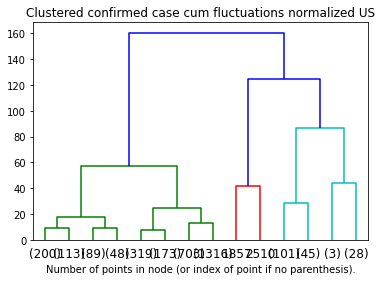

In [238]:
x = confirmedD.to_numpy()
cfm_model = AgglomerativeClustering(n_clusters=None, distance_threshold=60)
cfm_model = cfm_model.fit(x)


plt.title('Clustered confirmed case cum fluctuations normalized US')
plot_dendrogram(cfm_model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

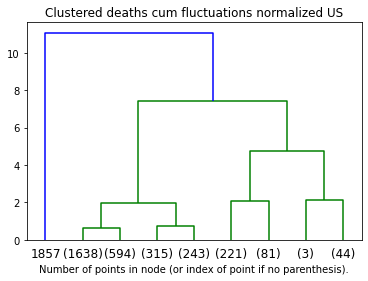

In [221]:
x = deathsD.to_numpy()
deaths_model = AgglomerativeClustering(n_clusters=None, distance_threshold=3)
deaths_model = deaths_model.fit(x)

plt.title('Clustered deaths cum fluctuations normalized US')
# plot the top three levels of the dendrogram
plot_dendrogram(deaths_model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [222]:
print(model.n_clusters_)
print(model.labels_)
all_fips = confirmedD.index
print(all_fips[1857])

40
[13  6  5 ... 23 13 15]
36061


In [239]:
def cluster_counties(model, counties=all_fips):
  cnt = np.asarray(counties)
  clt = {}
  for L in np.unique(model.labels_):
    mask = np.where(model.labels_ == L, True, False)
    counties_in_cluster = all_fips[mask]
    clt["Cluster {}".format(L)] = counties_in_cluster.map(lambda x: translate_FIPS(x, LU))
  return clt

cluster_counties(deaths_model)

{'Cluster 0': Index(['Tallapoosa, Alabama, US', 'Morgan, Colorado, US',
        'Fairfield, Connecticut, US', 'Hartford, Connecticut, US',
        'Clay, Georgia, US', 'Dougherty, Georgia, US', 'Early, Georgia, US',
        'Mitchell, Georgia, US', 'Randolph, Georgia, US', 'Sumter, Georgia, US',
        'Terrell, Georgia, US', 'Turner, Georgia, US', 'Upson, Georgia, US',
        'Wilcox, Georgia, US', 'Decatur, Indiana, US', 'Tama, Iowa, US',
        'Coffey, Kansas, US', 'Bienville, Louisiana, US',
        'East Feliciana, Louisiana, US', 'Iberville, Louisiana, US',
        'Jefferson, Louisiana, US', 'Orleans, Louisiana, US',
        'St. James, Louisiana, US', 'St. John the Baptist, Louisiana, US',
        'West Baton Rouge, Louisiana, US', 'Hampden, Massachusetts, US',
        'Wayne, Michigan, US', 'Holmes, Mississippi, US',
        'Wilkinson, Mississippi, US', 'Toole, Montana, US',
        'Bergen, New Jersey, US', 'Essex, New Jersey, US',
        'Hudson, New Jersey, US', 'Merc

In [240]:
cluster_counties(cfm_model)

{'Cluster 0': Index(['Autauga, Alabama, US', 'Baldwin, Alabama, US', 'Barbour, Alabama, US',
        'Bibb, Alabama, US', 'Blount, Alabama, US', 'Bullock, Alabama, US',
        'Calhoun, Alabama, US', 'Cherokee, Alabama, US', 'Chilton, Alabama, US',
        'Choctaw, Alabama, US',
        ...
        'Niobrara, Wyoming, US', 'Park, Wyoming, US', 'Platte, Wyoming, US',
        'Sheridan, Wyoming, US', 'Sublette, Wyoming, US',
        'Sweetwater, Wyoming, US', 'Teton, Wyoming, US', 'Uinta, Wyoming, US',
        'Washakie, Wyoming, US', 'Weston, Wyoming, US'],
       dtype='object', length=2961),
 'Cluster 1': Index(['Lincoln, Arkansas, US', 'Early, Georgia, US', 'Randolph, Georgia, US',
        'Terrell, Georgia, US', 'Blaine, Idaho, US', 'Cass, Indiana, US',
        'Louisa, Iowa, US', 'Finney, Kansas, US', 'Ford, Kansas, US',
        'Seward, Kansas, US', 'Nobles, Minnesota, US', 'Colfax, Nebraska, US',
        'Dakota, Nebraska, US', 'Dawson, Nebraska, US', 'Saline, Nebraska, US',
  